In [90]:
import os
import argparse
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, ELU, Lambda, Dropout, Flatten, Dense

In [44]:
# Display settings
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [189]:
def load_data(data_folders):
    dfs = []
    for d in data_folders:
        df = pd.read_csv(d + 'driving_log.csv') 
        df.center = d + df.center.str.strip()
        df.left = d + df.left.str.strip()
        df.right = d + df.right.str.strip()
        dfs.append(df.copy())
    return pd.concat(dfs, ignore_index=True)

In [194]:
def shift_steering(df, shift_value=0.25):
    center = df[['center', 'steering']].rename(columns={'center': 'image_path'})
    left = df[['left', 'steering']].rename(columns={'left': 'image_path'})
    right = df[['right', 'steering']].rename(columns={'right': 'image_path'})
    left['steering'] = np.minimum(left['steering'] + shift_value, 1.)
    right['steering'] = np.maximum(right['steering'] - shift_value, -1.)
    return pd.concat((center, left, right), ignore_index=True)

In [452]:
def gen(df, preprocess_f, batch_size=128):
    X, y = [], []
    while 1:
        df = shuffle(df)
        for idx, row in df.iterrows():
            image = cv2.imread(row['image_path'])
            image = preprocess_f(image)
            image = image[None, :, :, :]
            X.append(image)
            y.append([row['steering']])
            if len(X) >= batch_size:
                yield np.vstack(X), np.array(y)
                X, y = [], []

In [455]:
next(g)[0]

array([[[[185, 145, 116],
         [185, 145, 116],
         [184, 144, 115],
         ..., 
         [  0,  23,  19],
         [ 20,  41,  38],
         [  0,   8,   3]],

        [[185, 145, 116],
         [185, 145, 116],
         [185, 145, 116],
         ..., 
         [  0,  16,  12],
         [ 67,  94,  90],
         [ 94, 125, 118]],

        [[186, 146, 117],
         [186, 146, 117],
         [186, 146, 117],
         ..., 
         [ 73, 107, 101],
         [ 41,  79,  73],
         [ 55,  96,  88]],

        ..., 
        [[ 66,  77,  75],
         [ 62,  73,  71],
         [ 56,  67,  65],
         ..., 
         [ 88, 105, 108],
         [ 88, 105, 108],
         [ 87, 104, 107]],

        [[ 52,  63,  61],
         [ 49,  60,  58],
         [ 46,  57,  55],
         ..., 
         [ 89, 106, 109],
         [ 86, 103, 106],
         [ 86, 103, 106]],

        [[ 47,  58,  56],
         [ 49,  60,  58],
         [ 52,  63,  61],
         ..., 
         [ 94, 111, 114],
  

In [430]:
np.vstack(b)

array([[0],
       [1],
       [2]])

In [192]:
df = load_data(['./data/sim_data/','./data/udacity_data/'])

In [416]:
sample = df.sample(1)
img = cv2.imread(sample.image_path.values[0])
steer = sample.steering.values[0]

0.25


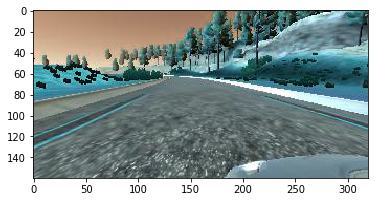

In [422]:
plt.imshow(img)
print(steer)

-0.25


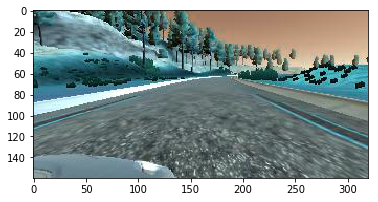

In [426]:
new_img, new_steer = random_flip(img, steer)
plt.imshow(new_img)
print(new_steer)